In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def scale_data(X_train, X_test, X_val, y_train, y_test, y_val):
    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    X_val_scaled = X_scaler.transform(X_val)
    
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    y_val_scaled = y_scaler.transform(y_val)
    
    return X_train_scaled, X_test_scaled, X_val_scaled, y_train_scaled, y_test_scaled, y_val_scaled

In [27]:
import pandas as pd
import numpy as np

df_load = pd.read_csv("load_data_track1.csv", parse_dates=True, index_col=0)
# wind_df = pd.read_csv("wind_data_all_zone.csv")
# solar_df = pd.read_csv("solar_new.csv")

features = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w 7', 'w8', 'w9', 'w10',
            'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20',
            'w21', 'w22', 'w23', 'w24', 'w25']
max_load = df_load['LOAD'].max()

df_x = df_load[features]
df_y = df_load['LOAD']/max_load

In [31]:
test_size = 0.25
random_state = 0

df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,
                                                                random_state=random_state, shuffle=True)

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

num_quantiles = 10
quantiles = np.arange(0, 1, 1/num_quantiles)[1:]
#quantiles = [0.05, 0.5, 0.95]

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    min_samples_leaf=9,
    min_samples_split=9,
)


for alpha in quantiles:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(df_x_train, df_y_train)

In [ ]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(df_x_train, df_y_train)

In [75]:
predictions = []
for name, gbr in sorted(all_models.items()):
    if name != "mse":
        y_pred = gbr.predict(df_x_TEST)

        predictions.append(y_pred)


predictions = np.array(predictions)
sorted_predictions = np.sort(predictions, axis=0)

results = []
for i, q in enumerate(quantiles):
    results.append(mean_pinball_loss(df_y_TEST, sorted_predictions[i], alpha=q))

Pinball loss of q=0.5 of MSE model 0.02471066747667758
Pinball loss of q=0.5 of quantile model 0.024892547923597824


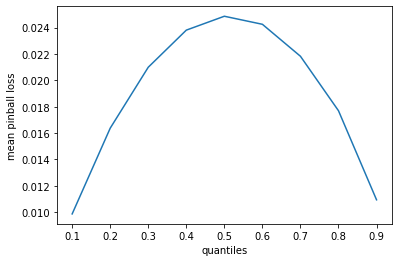

In [80]:
import matplotlib.pyplot as plt

print("Pinball loss of q=0.5 of MSE model", mean_pinball_loss(df_y_TEST, all_models["mse"].predict(df_x_TEST), alpha=0.5))
print("Pinball loss of q=0.5 of quantile model", mean_pinball_loss(df_y_TEST, all_models["q 0.50"].predict(df_x_TEST), alpha=0.5))
plt.plot(quantiles, results)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()